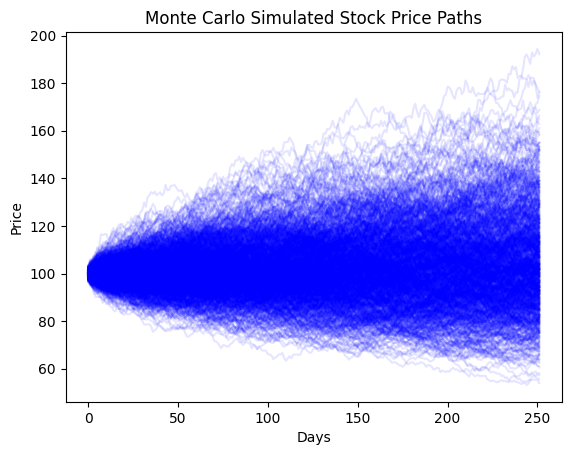

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100     # Initial stock price
mu = 0.05    # Expected return
sigma = 0.2  # Volatility
T = 1        # Time in years
dt = 1/252   # Daily steps
N = int(T/dt)
n_simulations = 1000

# Simulate
paths = np.zeros((n_simulations, N))
for i in range(n_simulations):
    Z = np.random.normal(size=N)
    S = [S0]
    for z in Z:
        S.append(S[-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z))
    paths[i] = S[1:]

# Plot
plt.plot(paths.T, alpha=0.1, color='blue')
plt.title("Monte Carlo Simulated Stock Price Paths")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()


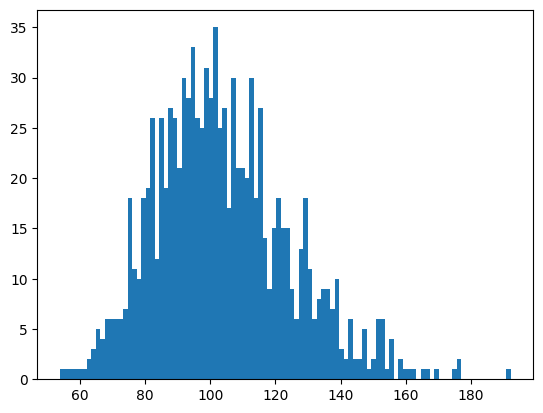

In [ ]:
h = plt.hist(paths[:, -1], bins = 100)

In [ ]:
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

ticker_symbol = "PREIX"  #  T. Rowe Price Equity Index 500 Fund
start_date = "2000-01-01"
end_date = "2024-04-10"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01',
               '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05',
               '2024-04-08', '2024-04-09'],
              dtype='datetime64[ns]', name='Date', length=6332, freq='B')

In [ ]:
import pandas as pd

# Assuming you have a DataFrame 'stock_data' with a column 'Close' for stock closing prices
stock_data['Daily Return'] = stock_data['Close'].pct_change()  # percentage return

In [ ]:
start_date = "2024-04-10"
end_date = "2025-04-10"
stock_data_future = get_stock_data(ticker_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


(-0.05, 0.05)

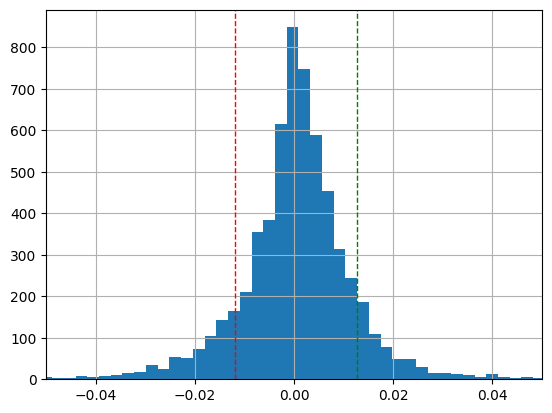

In [ ]:
import matplotlib.pyplot as plt
stock_data['Daily Return'].hist(bins = 100)
plt.axvline(x=up_threshold, color='green', linestyle='--', linewidth=1, label='Up Threshold')
plt.axvline(x=down_threshold, color='red', linestyle='--', linewidth=1, label='Down Threshold')
plt.xlim(-0.05, 0.05)

In [ ]:
stock_data['Close']

Ticker,PREIX
Date,
2000-01-03,25.353554
2000-01-04,24.382900
2000-01-05,24.434658
2000-01-06,24.460541
2000-01-07,25.127058
...,...
2025-04-03,141.889999
2025-04-04,133.429993
2025-04-07,133.119995


In [ ]:
mean_return = stock_data['Daily Return'].mean()
std_return = stock_data['Daily Return'].std()

# Define thresholds
up_threshold = mean_return + std_return
down_threshold = mean_return - std_return

In [ ]:
def classify_state(return_value, up_thresh, down_thresh):
    if return_value > up_thresh:
        return 'Up'
    elif return_value < down_thresh:
        return 'Down'
    else:
        return 'Stagnant'

stock_data['Markov State'] = stock_data['Daily Return'].apply(lambda x: classify_state(x, up_threshold, down_threshold))


In [ ]:
# Shift 'Markov State' column to get previous state
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create a transition matrix and Normalize to get probabilities
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

In [ ]:
transition_matrix

Markov State,Down,Stagnant,Up
Prev State,,,
Down,0.158501,0.649856,0.191643
Stagnant,0.095399,0.822094,0.082507
Up,0.166397,0.718901,0.114701


In [ ]:
stock_data['Markov State']

,Markov State
Date,
2000-01-03,Stagnant
2000-01-04,Down
2000-01-05,Stagnant
2000-01-06,Stagnant
2000-01-07,Up
...,...
2024-09-24,Stagnant
2024-09-25,Stagnant
2024-09-26,Stagnant


In [ ]:
transition_matrix

Markov State,Down,Stagnant,Up
Prev State,,,
Down,0.158824,0.650000,0.191176
Stagnant,0.095315,0.821132,0.083553
Up,0.166395,0.717781,0.115824


In [ ]:
import numpy as np

def find_equilibrium(transition_matrix):
    # Add a small number to ensure the matrix is not singular
    transition_matrix = transition_matrix + 1e-6
    # Initialize the equilibrium vector
    equilibrium = np.random.rand(transition_matrix.shape[0])
    # Normalize the equilibrium vector
    equilibrium = equilibrium / np.sum(equilibrium)
    # Iterate until convergence
    # print(equilibrium, transition_matrix)
    count = 0
    while True:
        new_equilibrium = np.dot(equilibrium, transition_matrix)
        # Check for convergence
        if np.allclose(equilibrium, new_equilibrium):
            break
        # Update the equilibrium vector
        equilibrium = new_equilibrium
        count += 1
    return equilibrium, count

# Calculate transition matrix

equilibrium, count = find_equilibrium(transition_matrix)
print(equilibrium, count)


[0.1091128  0.79145828 0.09944692] 6


In [ ]:
states = ['Down', 'Stagnant', 'Up']

In [ ]:
stock_data['Close'].iloc[-1]

,2025-04-09
Ticker,
PREIX,143.490005


In [ ]:
initial_state, current_state

('Up',)

In [ ]:
transition_matrix.loc[current_state].values

array([0.15850144, 0.64985591, 0.19164265])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Fit the Student's t distribution to the returns data
params = t.fit(stock_data['Daily Return'].dropna())

# Get the parameters of the distribution
df_t, mu, sigma = params

# from above
print("Transition Matrix:\n", transition_matrix)
initial_price = stock_data['Close'].iloc[-1]  # Initial stock price

# 4. Monte Carlo Simulation based on Markov Chain
n_simulations = 1000  # Number of simulation paths
n_days = 252  # Simulate for 1 year (252 trading days)

# Initial state probabilities
initial_state = stock_data['Markov State'].iloc[-1]
initial_state_probabilities = [1 if state == initial_state else 0 for state in states]

# Simulating the paths
simulated_paths = []
for sim in range(n_simulations):
    simulated_returns = []
    current_state = np.random.choice(states, p=initial_state_probabilities)

    for day in range(n_days):
        # Simulate return based on the current state using Student's t-distribution
        if current_state == "Up":
            daily_return = t.rvs(df_t, loc=mu + sigma, scale=sigma)
        elif current_state == "Down":
            daily_return = t.rvs(df_t, loc=mu - sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)

        simulated_returns.append(daily_return)
        # Transition to the next state based on the transition matrix
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state].values)

    # Cumulative price based on returns
    simulated_prices = initial_price.iloc[0] * np.exp(np.cumsum(simulated_returns))
    simulated_paths.append(simulated_prices)

# Convert the list of paths to a DataFrame
simulated_paths_df = pd.DataFrame(simulated_paths).T



Transition Matrix:
 Markov State      Down  Stagnant        Up
Prev State                                
Down          0.157658  0.648649  0.193694
Stagnant      0.095218  0.820327  0.084455
Up            0.166392  0.718287  0.115321


np.float64(143.4564585734753)

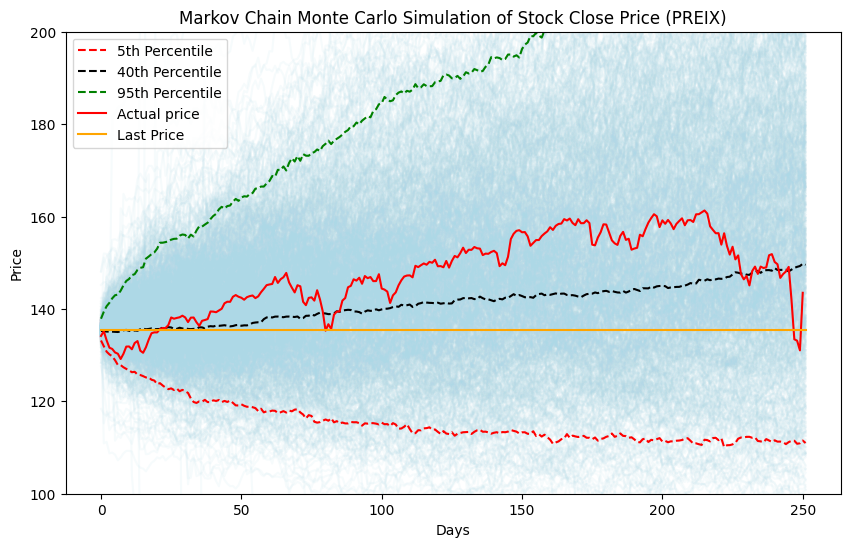

In [ ]:
# 5. Plotting the Monte Carlo simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)

# Add 5% and 95% percentile lines
percentiles_5 = simulated_paths_df.quantile(0.05, axis=1)
percentiles_95 = simulated_paths_df.quantile(0.95, axis=1)
percentiles_40 = simulated_paths_df.quantile(0.40, axis=1)

plt.plot(percentiles_5, color="red", linestyle="--", label="5th Percentile")
plt.plot(percentiles_40, color="black", linestyle="--", label="40th Percentile")
plt.plot(percentiles_95, color="green", linestyle="--", label="95th Percentile")

plt.plot(days[:-1], stock_data_future["Close"], color="red", label="Actual price")

days = range(252)
last_price = stock_data['Close'].iloc[-1].iloc[0]
plt.plot(days, last_price * np.ones(len(days)), color="orange", label="Last Price")

# Add labels and title
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol})")
plt.xlabel("Days")
plt.ylabel("Price")
plt.ylim(100, 200)
plt.legend()
plt.show()


In [ ]:
percentiles_40.iloc[-1], stock_data_future["Close"].iloc[-1].iloc[0]

(np.float64(149.54210835677864), np.float64(143.49000549316406))

In [ ]:
stock_data_future["Close"]

Ticker,PREIX
Date,
2024-04-10,134.156097
2024-04-11,135.164139
2024-04-12,133.207367
2024-04-15,131.606400
2024-04-16,131.339569
...,...
2025-04-03,141.889999
2025-04-04,133.429993
2025-04-07,133.119995


<Axes: >

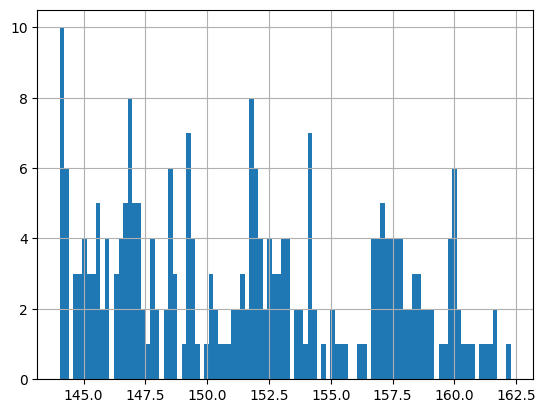

In [ ]:
initial_price.iloc[0]

np.float64(150.63925170898438)

In [ ]:
# 6. Computing VaR (Value at Risk)
final_prices = simulated_paths_df.iloc[-1]
losses = initial_price.iloc[0] - final_prices
confidence_level = 0.95

# VaR at 95% confidence level
var_95 = np.percentile(losses, (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at 95% confidence level: {var_95:.2f}")

# 7. Computing Confidence Intervals
mean_final_price = np.mean(final_prices)
std_final_price = np.std(final_prices)
ci_95 = norm.interval(0.95, loc=mean_final_price, scale=std_final_price)

print(f"95% Confidence Interval for the final price: {ci_95}")

Value at Risk (VaR) at 95% confidence level: -105.40
95% Confidence Interval for the final price: (np.float64(94.23633481223216), np.float64(267.7301938383778))


<Axes: >

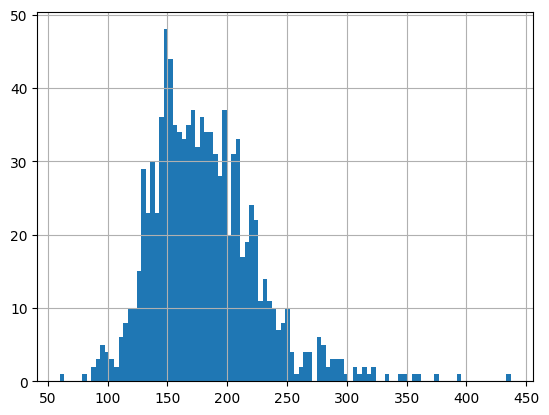

In [ ]:
final_prices.hist(bins=100)

In [ ]:
# Calculate the RSI Indicator
def calculate_rsi(data, window=14):
    delta = data["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)  # Filling NaN with 50 (neutral RSI)

In [ ]:
stock_data['rsi'] = calculate_rsi(stock_data, window=14)

In [ ]:
def classify_state(return_value, up_thresh, down_thresh):
    if return_value > up_thresh:
        return 'Up'
    elif return_value < down_thresh:
        return 'Down'
    else:
        return 'Stagnant'

up_threshold = 70
down_threshold = 30
stock_data['Markov State'] = stock_data['rsi'].apply(lambda x: classify_state(x, up_threshold, down_threshold))


In [ ]:
# Shift 'Markov State' column to get previous state
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create a transition matrix and Normalize to get probabilities
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)


In [ ]:
transition_matrix

Markov State,Down,Stagnant,Up
Prev State,,,
Down,0.603352,0.396648,0.000000
Stagnant,0.030136,0.914686,0.055178
Up,0.000000,0.224437,0.775563


In [ ]:
import numpy as np

def find_equilibrium(transition_matrix):
    # Add a small number to ensure the matrix is not singular
    transition_matrix = transition_matrix + 1e-6
    # Initialize the equilibrium vector
    equilibrium = np.random.rand(transition_matrix.shape[0])
    # Normalize the equilibrium vector
    equilibrium = equilibrium / np.sum(equilibrium)
    # Iterate until convergence
    while True:
        new_equilibrium = np.dot(equilibrium, transition_matrix)
        # Check for convergence
        if np.allclose(equilibrium, new_equilibrium):
            break
        # Update the equilibrium vector
        equilibrium = new_equilibrium
    return equilibrium

# Calculate transition matrix

equilibrium = find_equilibrium(transition_matrix)
print(equilibrium)


[0.05748711 0.75661189 0.18601201]


Transition Matrix:
 Markov State      Down  Stagnant        Up
Prev State                                
Down          0.603352  0.396648  0.000000
Stagnant      0.030136  0.914686  0.055178
Up            0.000000  0.224437  0.775563


<ipython-input-53-b728ba2b32f5>:44: RuntimeWarning: overflow encountered in exp
  simulated_prices = initial_price.iloc[0] * np.exp(np.cumsum(simulated_returns))
<ipython-input-53-b728ba2b32f5>:44: RuntimeWarning: overflow encountered in multiply
  simulated_prices = initial_price.iloc[0] * np.exp(np.cumsum(simulated_returns))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_base.py:3024: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


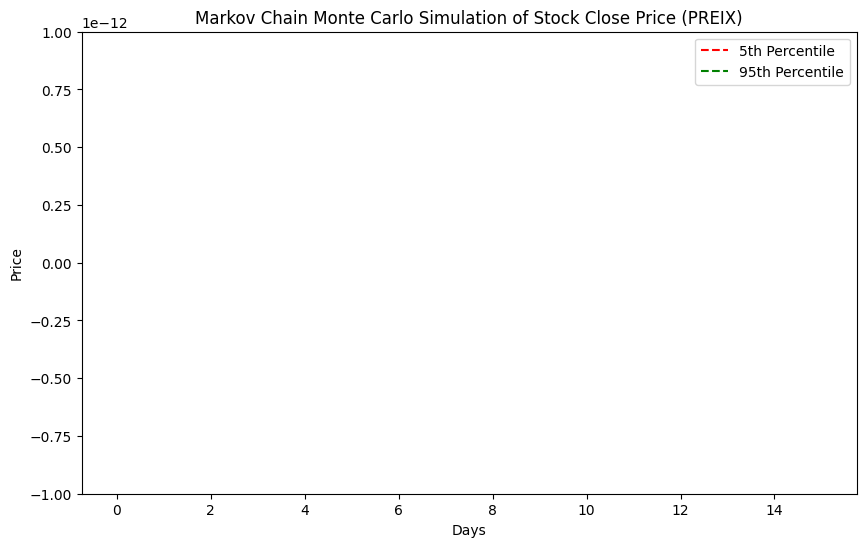

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Fit the Student's t distribution to the returns data
params = t.fit(stock_data['rsi'].dropna())

# Get the parameters of the distribution
df_t, mu, sigma = params

# from above
print("Transition Matrix:\n", transition_matrix)
initial_price = stock_data['Close'].iloc[-1]  # Initial stock price

# 4. Monte Carlo Simulation based on Markov Chain
n_simulations = 1000  # Number of simulation paths
n_days = 252  # Simulate for 1 year (252 trading days)

# Initial state probabilities
initial_state = stock_data['Markov State'].iloc[-1]
initial_state_probabilities = [1 if state == initial_state else 0 for state in states]

# Simulating the paths
simulated_paths = []
for sim in range(n_simulations):
    simulated_returns = []
    current_state = np.random.choice(states, p=initial_state_probabilities)

    for day in range(n_days):
        # Simulate return based on the current state using Student's t-distribution
        if current_state == "Up":
            daily_return = t.rvs(df_t, loc=mu + sigma, scale=sigma)
        elif current_state == "Down":
            daily_return = t.rvs(df_t, loc=mu - sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)

        simulated_returns.append(daily_return)
        # Transition to the next state based on the transition matrix
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state].values)

    # Cumulative price based on returns
    simulated_prices = initial_price.iloc[0] * np.exp(np.cumsum(simulated_returns))
    simulated_paths.append(simulated_prices)

# Convert the list of paths to a DataFrame
simulated_paths_df = pd.DataFrame(simulated_paths).T

# 5. Plotting the Monte Carlo simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)

# Add 5% and 95% percentile lines
percentiles_5 = simulated_paths_df.quantile(0.05, axis=1)
percentiles_95 = simulated_paths_df.quantile(0.95, axis=1)

plt.plot(percentiles_5, color="red", linestyle="--", label="5th Percentile")
plt.plot(percentiles_95, color="green", linestyle="--", label="95th Percentile")

# Add labels and title
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol})")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
simulated_returns

[np.float64(69.97608440261945),
 np.float64(81.4296240104891),
 np.float64(83.78145755409425),
 np.float64(38.29921374650141),
 np.float64(66.28182656344546),
 np.float64(81.9111194142016),
 np.float64(44.811319279346336),
 np.float64(62.61602107494824),
 np.float64(74.23768157409417),
 np.float64(35.321853473035574),
 np.float64(41.139874917199805),
 np.float64(37.11735154811072),
 np.float64(74.71015437141305),
 np.float64(65.56044722661011),
 np.float64(57.13826710189897),
 np.float64(11.79717566048744),
 np.float64(52.73728092909082),
 np.float64(63.28716608733666),
 np.float64(53.23025258775439),
 np.float64(51.6003736866481),
 np.float64(70.9128472415089),
 np.float64(61.85801320803314),
 np.float64(54.15077729503958),
 np.float64(73.55996577662268),
 np.float64(50.01567684097598),
 np.float64(58.00868960753076),
 np.float64(55.81214583373256),
 np.float64(23.667884885674066),
 np.float64(56.7581818114783),
 np.float64(61.473214404955705),
 np.float64(67.12914696176011),
 np.floa